In [2]:
# importing libraries

import pandas as pd
from sqlalchemy import create_engine as ce
import math
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import column, grid
from bokeh.models import Band, ColumnDataSource
from sqlalchemy import create_engine, MetaData, Table, Column, Float, String
import seaborn as sns
import matplotlib.pyplot as plt
from unittest import TestCase



In [3]:
#### all functions #####

"""
all Functions

"""



class FuncMgr:
    try:
        def __init__(self, CSV_path):
                
                """The provided function parses a local CSV file and converts it into a list of Functions. 
                When iterating over the object, it returns a Function. The functions can also be accessed using the 
                ".functions" property. The CSV file must follow a specific structure where the first column represents 
                x-values, and subsequent columns represent y-values. The function requires the parameter "path_of_csv," 
                which is the local path of the CSV file.
                """
                self._func_s = []

                #reading CSV with Pandas and converting into dataframe
                try:
                    self._func_data = pd.read_csv(CSV_path)
                except FileNotFoundError:
                    print("Issue while reading file {}".format(CSV_path))
                    raise

                # x value is stored and used later in functions 
                x_values = self._func_data["x"]

                #The following lines of code iterate over each column in a pandas dataframe and create a new Function object using the data.

                for n_of_col, data_of_col in self._func_data.items():
                    if "x" in n_of_col:
                        continue
                    """
                    stored "x" Col we now have "y" Col .Concat functions together
                    """
                    subs = pd.concat([x_values, data_of_col], axis=1)
                    func = Func.from_The_dataframe(n_of_col, subs)
                    self._func_s.append(func)
            

        def to_sql(self, f_n, suff):
            # with the help of SQLalchemy Engine is created "Eng". creating  and handeling the database if it dose not exist.
            Eng = ce('sqlite:///{}.db'.format(f_n), echo=False)
            """
            using pandas functions for sql database
            uning "engin" object form SQLachemny
            """
                
            co_of_func_data = self._func_data.copy()
            co_of_func_data.columns = [name.capitalize() + suff for name in co_of_func_data.columns]
            co_of_func_data.set_index(co_of_func_data.columns[0], inplace=True)

            co_of_func_data.to_sql(
                f_n,
                Eng,
                if_exists="replace",
                index=True,
            )
            

        @property
        def funcs(self):
            """
            Gives back the list All the functinos. 

            """


            return self._func_s
            
        def __iter__(self):
            # the function maked the obj to itrate
            return FuncMgrIterator(self)


        def __repr__(self):
            return "Contains {} number of funcs".format(len(self.funcs))
    except Exception as e:
        print("Error in FuncMgr"+ str(e))

class FuncMgrIterator():
    try:
        def __init__(self, func_mgr):
                """ 
            used for Func_manager itrations
            """         

                self._index = 0
                self._func_mgr = func_mgr


        def __next__(self):
            """ 
            GIves back a function obj as it itreate over the listed functions
            """
            if self._index < len(self._func_mgr.funcs):
                value_req = self._func_mgr.funcs[self._index]
                self._index = self._index + 1
                return value_req
            raise StopIteration
    except Exception as e:
        print("Error in FuncMgrIterator"+ str(e))


class Func:
    try:    
        def __init__(self, name):
            """ 
            This class represents a function and contains the X and Y values of the function. It utilizes a Pandas dataframe for 
            storage and provides convenient methods for performing regressions. 
            Here are the key features of this class:
            1)You can assign a name to the function, which can be later retrieved.
            2)The class is iterable, allowing you to iterate over the function's points represented as dictionaries.
            3)You can retrieve the Y-value by providing an X-value.
            4)It supports subtraction of two functions, resulting in a dataframe that represents the deviation between them.
            The "name" parameter allows you to specify the desired name for the function.
            """
            self._name = name
            self.dataframe = pd.DataFrame()
            


        def locating_y_based_on_x(self, x):
                """ 
                To retrieve a Y-value from the function, you need to provide an X-value as input. The method takes the following parameters:
                x: The X-value for which you want to retrieve the Y-value.
                The method returns the corresponding Y-value.

                """
                # using pandas function iloc to find the corr "Y" to "x"
                # else exceptions are raised    
                search_k = self.dataframe["x"] == x
                try:
                    return self.dataframe.loc[search_k].iat[0, 1]
                except IndexError:
                    raise IndexError
            

        @property
        def name(self):
            """ 
            To retrieve the name of the function, you can call a method that returns the name as a string. 
            The method does not require any parameters. It simply returns the name of the function as a string.
            """
            return self._name
            

        def __iter__(self):
                return FuncIter(self)
            

        def __sub__(self, other):
                """ 
            To subtract two functions and obtain a new dataframe representing
            the deviation between them, you can use a specific method.
            This method returns an object of the resulting dataframe. 

            """
                diff = self.dataframe - other.dataframe
                return diff
            

        @classmethod
        def from_The_dataframe(cls, name, dataframe):
                """ 
                To create a function promptly by providing a dataframe, you can follow a specific procedure. During the creation process, the original
                column names in the dataframe will be replaced with "x" and "y" to represent the X and Y values, 
                respectively. The resulting function will be of type Function.

                """
                func = cls(name)
                func.dataframe = dataframe
                func.dataframe.columns = ["x", "y"]
                return func
            

        def __repr__(self):
            return "Function for {}".format(self.name)
    except Exception as e:
        print("Error in Func"+ str(e))        

class IdealFunc(Func):
    try:    
        def __init__(self, func, training_func, err):
                """ 
                An ideal function class is designed to store the predicting function, training data, and regression information. 
                It includes the option to provide a tolerance factor when classification requires tolerance allowance. 
                If no tolerance factor is provided, it will default to the maximum deviation between the ideal and training functions. 
                """
                super().__init__(func.name)
                self.dataframe = func.dataframe

                self.training_func = training_func
                self.err = err
                self._toler_value = 1
                self._toler = 1
            

        def _determine_largest_dev(self, ideal_func, train_func):
                # accepting two Func and substract 
                # form the results of the data_frame, finding the largest   
                distance_s = train_func - ideal_func
                distance_s["y"] = distance_s["y"].abs()
                large_dev = max(distance_s["y"])
                return large_dev
            

        @property
        def toler(self):  
                """ 
                This property represents the accepted tolerance for the regression in order to consider it as a successful classification. 
                It is recommended to provide a tolerance_factor instead of directly setting a tolerance value, especially for unit testing purposes.
        
                The tolerance property returns the tolerance value used for regression classification. 
                It is suggested to provide a tolerance_factor instead of directly assigning the tolerance value.

                """
                self._toler = self.toler_factor * self.large_dev
                return self._toler
            

        @toler.setter
        def toler(self, value):
            self._toler = value
            

        @property
        def toler_factor(self):
            """ 
            setting the factor of the larg_deviation to determining the tolarace
            and return value
            """
            return self._toler_value
            

        @toler_factor.setter
        def toler_factor(self, value):
                        self._toler_value = value
            

        @property
        def large_dev(self):
            """ 
            The largest difference between the classifying function and the training 
            function on which it is based is returned
            :return: the greatest divergence
            """
            large_dev = self._determine_largest_dev(self, self.training_func)
            return large_dev
    except Exception as e:
        print("Error in IdealFunc"+ str(e))    


class FuncIter:
    try:
        def __init__(self, func):
                # iteration of the function  which returns a dict that discribes the point
                self._function = func
                self._index = 0
            

        def __next__(self):
            # iteration of the function  which returns a dict that discribes the point
    
            if self._index < len(self._function.dataframe):
                value_req_series = (self._function.dataframe.iloc[self._index])
                point = {"x": value_req_series.x, "y": value_req_series.y}
                self._index += 1
                return point
            raise StopIteration
    except Exception as e:
        print("Error in FuncIter"+ str(e)) 



In [4]:
####  ploting  #####

def plot_ideal_func_s(ideal_func_s, f_n):
        try:    
                """  
                Plots all ideal functions with the following parameters: ideal_functions,
                a list of ideal functions, and file_name, the name of the.html file.
                """
                ideal_func_s.sort(key = lambda ideal_func: ideal_func.training_func.name, reverse=False)
                plots = []
                for ideal_func in ideal_func_s:
                        p = plot_graph_from_two_func_s(line_function=ideal_func, scatter_function=ideal_func.training_func,
                                                squared_err=ideal_func.err)
                        plots.append(p)
                output_file("{}.html".format(f_n))
                # Observing how Unpacking is used to give the arguments
                show(column(*plots))
        except Exception as e:
                print("Error in plot_ideal_func_s"+ str(e)) 


def plot_points_with_their_ideal_func(points_with_classi, f_n):
        try:
                """ 
                Plot all focuses that have a coordinated classification
                :param points_with_classification: a list containing dicts with "classification" and "point"
                :param file_name: the title the .html record ought to get refrase

                """
                plots = []
                for index, item in enumerate(points_with_classi):
                        if item["classi"] is not None:
                                p = plot_classi(item["point"], item["classi"])
                                plots.append(p)
                output_file("{}.html".format(f_n))
                show(column(*plots))
        except Exception as e:
                print("Error in plot_points_with_their_ideal_func"+ str(e))



def plot_graph_from_two_func_s(scatter_function, line_function, squared_err):
        try:
                """ 
                plots a diffuse for the train_function and a line for the ideal_function
                : param scatter_function: the prepare work
                : param line_function: perfect work
                : param squared_error: the squared blunder will be plotted within the title

                """        
                f1_dataframe = scatter_function.dataframe
                f1_name = scatter_function.name

                f2_dataframe = line_function.dataframe
                f2_name = line_function.name

                squared_err = round(squared_err, 2)
                p = figure(title="train model {} vs ideal {}. Total squared error = {}".format(f1_name, f2_name, squared_err),
                        x_axis_label='x', y_axis_label='y')
                p.scatter(f1_dataframe["x"], f1_dataframe["y"], fill_color="orange", legend_label="Train")
                p.line(f2_dataframe["x"], f2_dataframe["y"], legend_label="Ideal", line_width=1)
                return p
        except Exception as e:
                print("Error in plot_graph_from_two_func_s"+ str(e))


def plot_classi(point, ideal_func):
        try:
                """ 
                This analytical exercise entails plotting the classification function and placing a data point atop it. The display of tolerance is also exhibited.
                The parameter "point" is a dictionary containing key-value pairs for both "x" and "y".
                The parameter, "ideal_function," pertains to an object that is utilized for classification purposes.

                """        
                if ideal_func is not None:
                        classi_func_dataframe = ideal_func.dataframe

                        point_str = "({},{})".format(point["x"], round(point["y"], 1))
                        title = "point {} with classi: {}".format(point_str, ideal_func.name)

                        p = figure(title=title, x_axis_label='x', y_axis_label='y')
                        # Drawing the ideal_funtions
                        
                        p.line(classi_func_dataframe["x"], classi_func_dataframe["y"],
                                legend_label="classi function", line_width=1, line_color='black')

                        # The methodology for demonstrating the degree of tolerance on a graph.
                        criterion = ideal_func.toler
                        classi_func_dataframe['upper'] = classi_func_dataframe['y'] + criterion
                        classi_func_dataframe['lower'] = classi_func_dataframe['y'] - criterion

                        source = ColumnDataSource(classi_func_dataframe.reset_index())

                        band = Band(base='x', lower='lower', upper='upper', source=source, level='underlay',
                                fill_alpha=0.3, line_width=1, line_color='green', fill_color="green")

                        p.add_layout(band)

                        #Drawing Point
                        p.scatter([point["x"]], [round(point["y"], 4)], fill_color="orange", legend_label="Test point", size=10)

                        return p
        except Exception as e:
                print("Error in plot_classi"+ str(e))


In [5]:
### Reggre ####

def minimise_loss(training_func, list_of_candidate_func_s, loss_func):
        """ 
    Based on a training function and a list of ideal functions, this function outputs an IdealFunction:training function 
    :param L_of_ideal_funcs: list of candidate ideal functions
    :param lost_function: the function used to reduce error :an IdealFunction object is returned
    """

        try:    
            function_with_smallest_error = None
            smallest_error = None
            for func in list_of_candidate_func_s:
                err = loss_func(training_func, func)
                if ((smallest_error == None) or err < smallest_error):
                    smallest_error = err
                    function_with_smallest_error = func

            ideal_func = IdealFunc(func=function_with_smallest_error, training_func=training_func,
                                err=smallest_error)
            return ideal_func
        except Exception as e:
                print("Error in minimise_loss"+ str(e))
    

def find_classi(point, ideal_func_s):
    """ 
    It determines whether a point is inside a classification's tolerance:A dict object contains a "x" and a "y" as 
    parameters:ideal_functions: a list of Ideal functionsObjects of function:return: a tuple comprising, if any,
    the closest classification and the distance
    """
    try:
        current_lowest_classi = None
        current_lowest_dist = None

        for ideal_func in ideal_func_s:
            try:
                locate_y_in_classi = ideal_func.locating_y_based_on_x(point["x"])
            except IndexError:
                print("This point is not in the classi function")
                raise IndexError
            #observing  here how the abso dist is used
            
            dist = abs(locate_y_in_classi - point["y"])

            if (abs(dist < ideal_func.toler)):
                """ 
                This procedure ensures that there is handling if numerous classifications are possible.
                It returns the one with the Low  distance.
                """
                if ((current_lowest_classi == None) or (dist < current_lowest_dist)):
                    current_lowest_classi = ideal_func
                    current_lowest_dist = dist

        return current_lowest_classi, current_lowest_dist
    except Exception as e:
                print("Error in find_classi"+ str(e))


In [6]:
#### Utils  ####

def write_deviation_results_to_sqlite(result): 
        """ 
    The outcomes of a classification computation have the potential to be documented
    within a Sqlite database.
    This approach acknowledges the stipulated requirements outlined in the assignment.
    The parameter "result" entails a list containing a dictionary that describes the 
    outcome of a classification test.
    
    """
    # This function employs a methodology native to SQLAlchemy.
    # Instead of utilizing SQL syntax, the decision was made to utilize MetaData to
    #  delineate the attributes of the table as well as the respective columns.
    # The table creation process utilized by SQLAlchemy employs a particular 
    # type of data structure.
        try:    
            Eng = ce('sqlite:///{}.db'.format("mapping"), echo=False)
            meadata = MetaData()
            
            mapping =Table("mapping", meadata,
                        Column('X (test func)', Float, primary_key=False),
                        Column('Y (test func)', Float),
                        Column('Delta Y (test func)', Float),
                        Column('No. of ideal func', String(50))
            )
            meadata.create_all(Eng)
            """ 
            Instead of individually injecting values line by line, a method which is 
            relatively inefficient.
            The author opted to utilize SQLAlchemy's ".execute" method by employing 
            a dictionary that encompasses all pertinent values.
            The development of this dictionary entails a straightforward correspondence
            between my internal data structures and the mapping process.
            The requisite composition for the given task.

            """
            execute_map=[]
            for item in result:
                point = item["point"]
                classi  = item["classi"]
                delta_y = item["delta_y"]
                # We ought to test on the off chance that there's a classification for
                #  a point at all and in the event that so rename the work title to comply
                classi_name  = None
                if classi  is not None:
                    classi_name = classi.name.replace("Y","N")
                else:
                #In case there's no classification, there's too no remove. In that case I 
                # compose a sprint

                    classi_name = "-"
                    delta_y =-1
                res = {
                    'X (test func)': point["x"],
                    'Y (test func)': point["y"],
                    'Delta Y (test func)': delta_y,
                    'No. of ideal func': classi_name
                }
                # The insertion of data is facilitated through utilization of the Table object,
                # wherein the dict is applied.

                execute_map.append(res)

            with Eng.begin() as connection:
                connection.execute(mapping.insert(), execute_map)
        except Exception as e:
                print("Error in write_deviation_results_to_sqlite"+ str(e))
    

In [7]:
#### LOSS_FUNC ####
def squared_err(first_function, second_function):

    """ 
    finding the  **2 error of other functions
    oth_func
    return **2 error
    
    """
    try:    
        distance_s = second_function - first_function
        distance_s["y"] = distance_s["y"] ** 2
        total_deviation = sum(distance_s["y"])
        return total_deviation
    except Exception as e:
        print("Error in squared_err "+ str(e))


In [8]:
# Reading data(cvs)

train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
ideal_functions_data = pd.read_csv("data/ideal.csv")

In [9]:
#### MAIN LOOP ####


# This particular constant serves as the determining factor for the criterion and is tailored
# specifically to the assignment.


ACCEPTED_FACTOR = math.sqrt(2)


if __name__ == '__main__':
        #The paths for the CSV files are required to be furnished.
        test_path = "data/test.csv"   
        ideal_path = "data/ideal.csv"
        train_path = "data/train.csv"

        """
        The Function Manager takes in a CSV path and extracts Function objects from the data.
        pandas is used to for the effiiency the function stores 'x' and 'y' points.
        """    
        candidate_ideal_func_manager = FuncMgr(CSV_path=ideal_path)
        train_func_manager = FuncMgr(CSV_path=train_path)

        # Func_manager uses the to_sql function from panda
        # adding suffix to comply for the requirment of the structurig of the tables    
        train_func_manager.to_sql(f_n="training", suff=" (training func)")
        candidate_ideal_func_manager.to_sql(f_n="ideal", suff=" (ideal func)")

        """
        inside the Train funcion manager 4  functions are added.
        inside the ideal fuction manager 50 ideal functions are added.
        next the progarm computes all the datafor the ideal functions
        among the idealfunctions a best fit function is stored.after which the train data will be able 
        to find tolarance.
        ittrating the train functions
        after ittrating matching  idel functions are stored in a list.

        """    
        ideal_func_s = []
        for train_func in train_func_manager:
            #The Minimize_loss algorithm has the capability of effectively computing the optimal fitting 
            # function based on the provided training function.

            ideal_func = minimise_loss(training_func=train_func,
                                        list_of_candidate_func_s=candidate_ideal_func_manager.funcs,
                                        loss_func=squared_err)
            ideal_func.toler_factor = ACCEPTED_FACTOR
            ideal_func_s.append(ideal_func)
            
        # plottting and classifications 
    
        plot_ideal_func_s(ideal_func_s, "train_and_ideal")

        # It is now time to examine all points in the test data. 
        # The FunctionManager offers everything needed to load a CSV, therefore it will be reused.
        # Instead of numerous Functions, there will now be a single "Function" at location [0].
        # The advantage is that we can use the Function object to iterate over each point.
            
        test_path = "data/test.csv"
        test_function_manager = FuncMgr(CSV_path=test_path)
        test_function = test_function_manager.funcs[0]

        points_with_ideal_func = []
        for point in test_function:
            ideal_func, delta_y = find_classi(point=point, ideal_func_s=ideal_func_s)
            result = {"point": point, "classi": ideal_func, "delta_y": delta_y}
            points_with_ideal_func.append(result)
        # A list of dictionaries is maintained in points_with_ideal_functions.
        # These dictionaries display how each point was classified.

        # Using the corresponding categorization function, we can plot each point.        
        plot_points_with_their_ideal_func(points_with_ideal_func, "point_and_ideal")
        # Finally, it is written to a sqlite database using the dict object.
        #To protect myself against SQL-Language, I've chosen a pure SQLAlchamy approach with a
        #MetaData object in this procedure.
        write_deviation_results_to_sqlite(points_with_ideal_func)
        print("Done")


Done


In [10]:
# test_data Importing

test_data.head(1000)

,x,y
0,-4.0,1.044171
1,19.6,5240.178700
2,-7.2,2.063293
3,-14.6,-43.106170
4,-17.4,-1.217196
...,...,...
95,10.9,-0.647010
96,-1.9,-2.322036
97,19.5,-0.028896
98,14.8,-1435.503500


In [11]:
# train_data Importing

train_data.head(1000)

,x,y1,y2,y3,y4
0,-20.0,-1.290358,0.971772,-8020.1840,-57.798700
1,-19.9,-0.856480,0.760779,-7900.3633,-57.248300
2,-19.8,-0.476500,1.072470,-7782.3230,-57.198140
3,-19.7,-1.240305,0.400996,-7665.4790,-57.041080
4,-19.6,-0.864219,0.624187,-7549.5490,-57.004307
...,...,...,...,...,...
395,19.5,0.976830,-0.942696,7434.5490,60.119160
396,19.6,0.462573,-0.947579,7548.7197,60.744850
397,19.7,0.915682,-1.033946,7664.7600,61.520294
398,19.8,1.196980,-0.955442,7781.9290,60.991844


In [12]:
# ideal_data Importing

ideal_functions_data.head(1000)

,x,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y41,y42,y43,y44,y45,y46,y47,y48,y49,y50
0,-20.0,-0.912945,0.408082,9.087055,5.408082,-9.087055,0.912945,-0.839071,-0.850919,0.816164,...,-40.456474,40.204040,2.995732,-0.008333,12.995732,5.298317,-5.298317,-0.186278,0.912945,0.396850
1,-19.9,-0.867644,0.497186,9.132356,5.497186,-9.132356,0.867644,-0.865213,0.168518,0.994372,...,-40.233820,40.048590,2.990720,-0.008340,12.990720,5.293305,-5.293305,-0.215690,0.867644,0.476954
2,-19.8,-0.813674,0.581322,9.186326,5.581322,-9.186326,0.813674,-0.889191,0.612391,1.162644,...,-40.006836,39.890660,2.985682,-0.008347,12.985682,5.288267,-5.288267,-0.236503,0.813674,0.549129
3,-19.7,-0.751573,0.659649,9.248426,5.659649,-9.248426,0.751573,-0.910947,-0.994669,1.319299,...,-39.775787,39.729824,2.980619,-0.008354,12.980619,5.283204,-5.283204,-0.247887,0.751573,0.612840
4,-19.6,-0.681964,0.731386,9.318036,5.731386,-9.318036,0.681964,-0.930426,0.774356,1.462772,...,-39.540980,39.565693,2.975530,-0.008361,12.975530,5.278115,-5.278115,-0.249389,0.681964,0.667902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,19.5,0.605540,0.795815,10.605540,5.795815,-10.605540,-0.605540,-0.947580,-0.117020,1.591630,...,39.302770,-38.602093,2.970414,-0.012422,12.970414,5.273000,-5.273000,0.240949,0.605540,0.714434
396,19.6,0.681964,0.731386,10.681964,5.731386,-10.681964,-0.681964,-0.930426,0.774356,1.462772,...,39.540980,-38.834310,2.975530,-0.012438,12.975530,5.278115,-5.278115,0.249389,0.681964,0.667902
397,19.7,0.751573,0.659649,10.751574,5.659649,-10.751574,-0.751573,-0.910947,-0.994669,1.319299,...,39.775787,-39.070175,2.980619,-0.012453,12.980619,5.283204,-5.283204,0.247887,0.751573,0.612840
398,19.8,0.813674,0.581322,10.813674,5.581322,-10.813674,-0.813674,-0.889191,0.612391,1.162644,...,40.006836,-39.309338,2.985682,-0.012469,12.985682,5.288267,-5.288267,0.236503,0.813674,0.549129


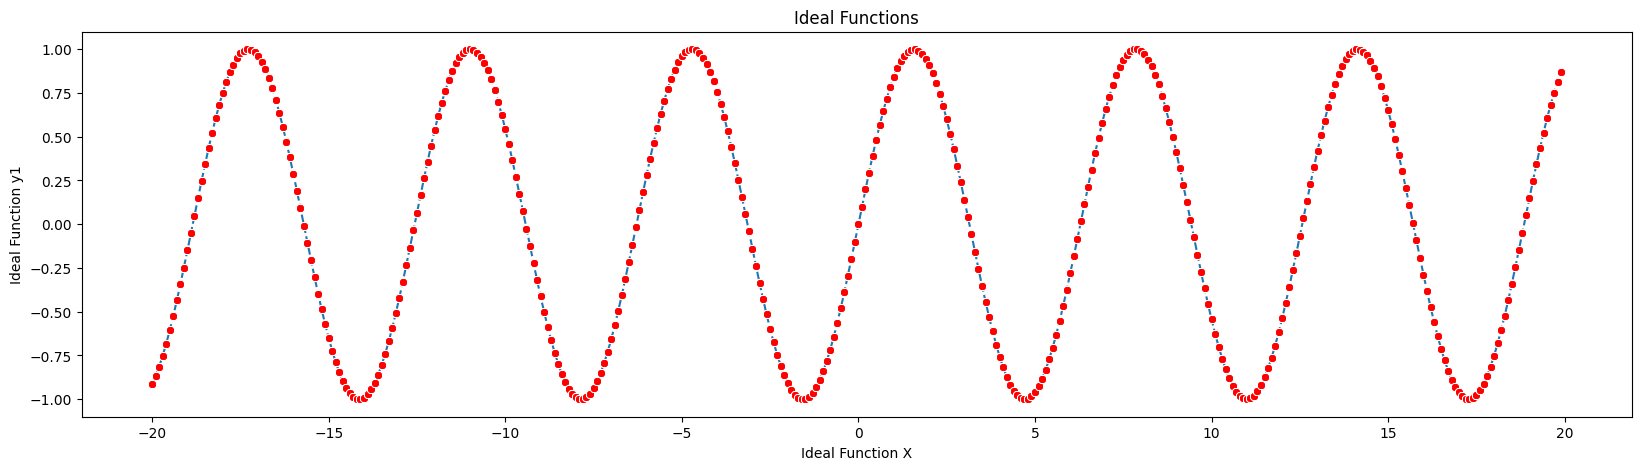

In [13]:
#ploting ideal Functions

plt.figure(figsize=(20,5))
sns.lineplot(x = ideal_functions_data ['x'], y = ideal_functions_data['y1'],marker="8",markerfacecolor="red", linestyle="--")
plt.xlabel('Ideal Function X')
plt.ylabel('Ideal Function y1')
plt.title('Ideal Functions')
plt.show()


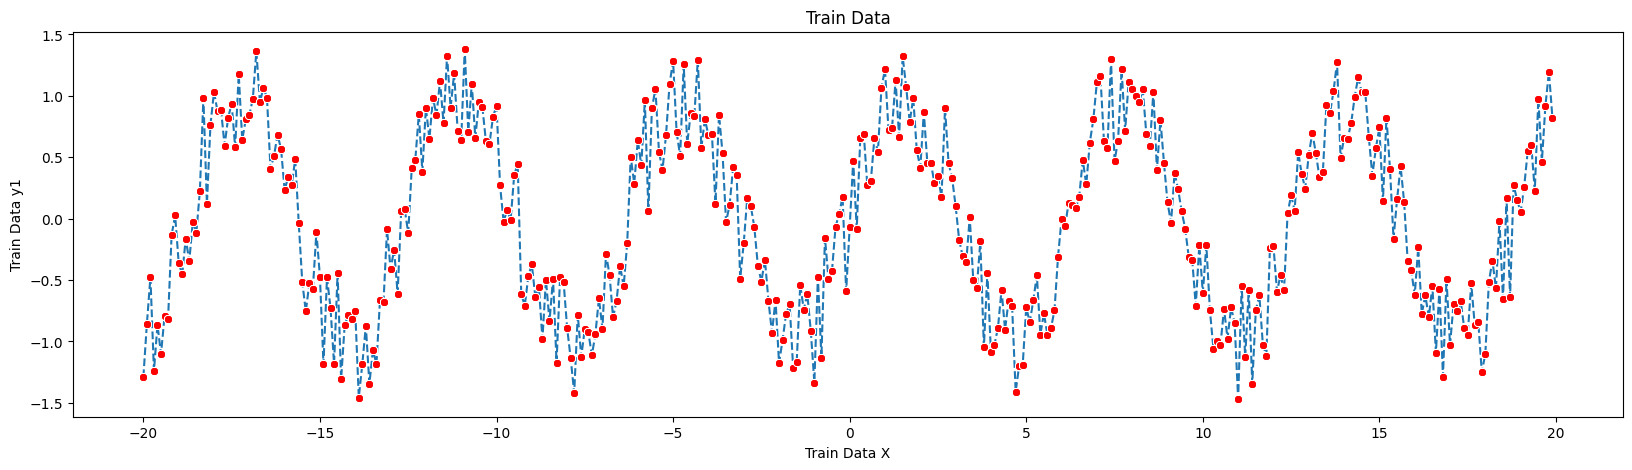

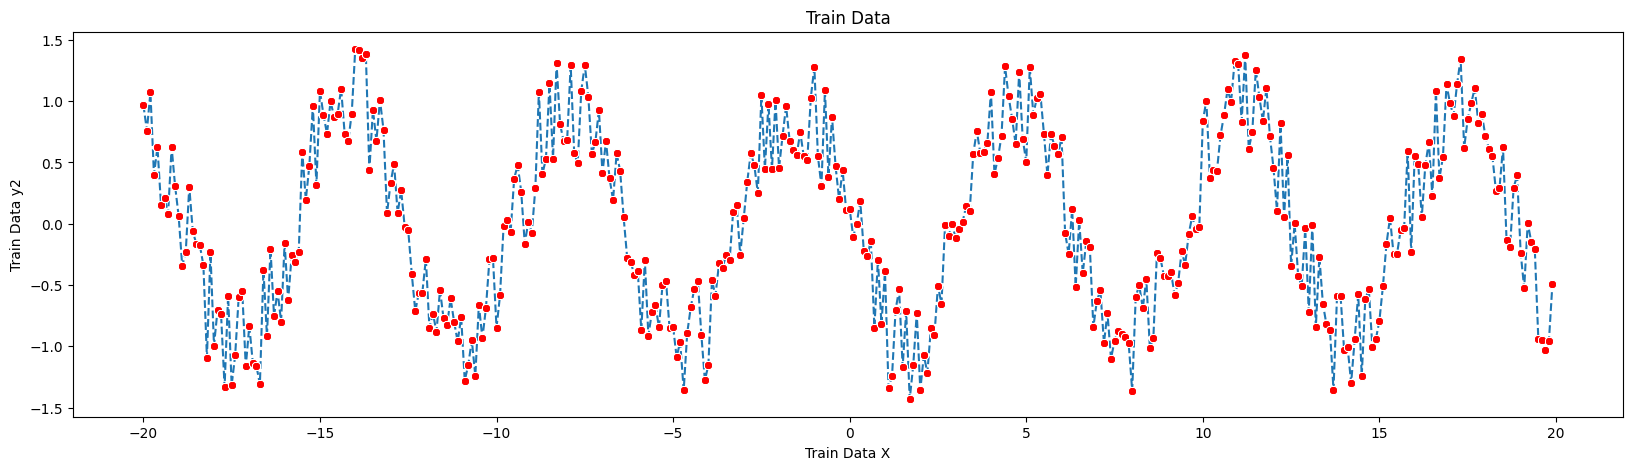

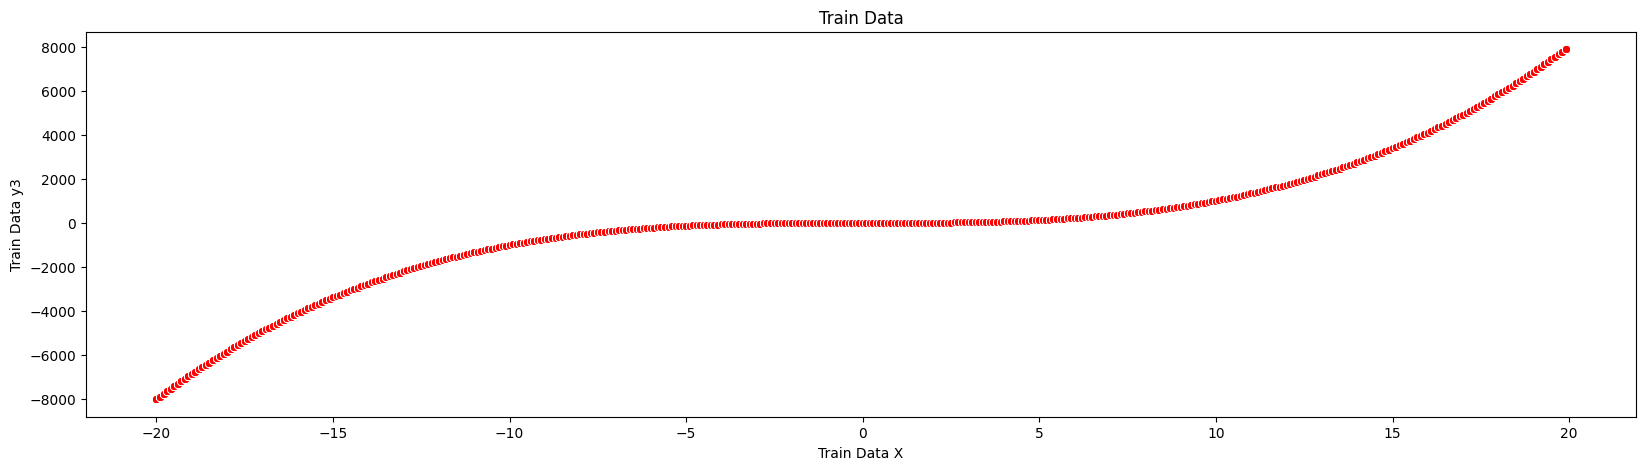

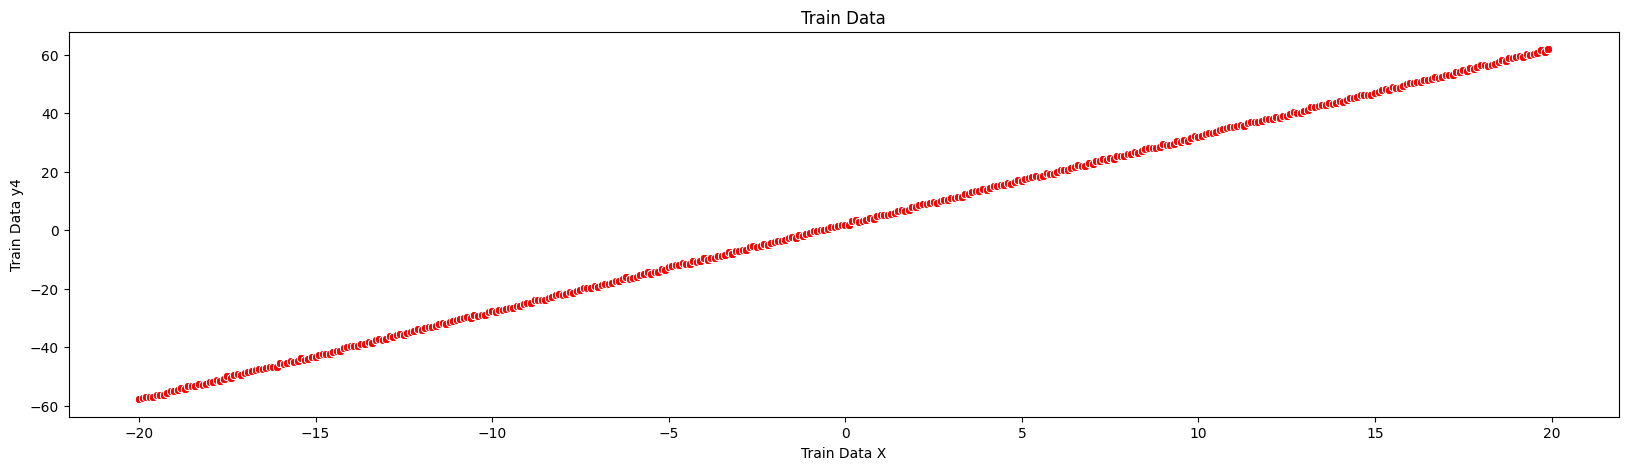

In [14]:
#ploting Train Data


plt.figure(figsize=(20,5))
sns.lineplot(x = train_data['x'], y = train_data['y1'],marker="8",markerfacecolor="red", linestyle="--")
plt.xlabel('Train Data X')
plt.ylabel('Train Data y1')
plt.title('Train Data')
plt.show()

plt.figure(figsize=(20,5))
sns.lineplot(x = train_data['x'], y = train_data['y2'],marker="8",markerfacecolor="red", linestyle="--")
plt.xlabel('Train Data X')
plt.ylabel('Train Data y2')
plt.title('Train Data')
plt.show()

plt.figure(figsize=(20,5))
sns.lineplot(x = train_data['x'], y = train_data['y3'],marker="8",markerfacecolor="red", linestyle="--")
plt.xlabel('Train Data X')
plt.ylabel('Train Data y3')
plt.title('Train Data')
plt.show()

plt.figure(figsize=(20,5))
sns.lineplot(x = train_data['x'], y = train_data['y4'], marker="8",markerfacecolor="red", linestyle="--")
plt.xlabel('Train Data X')
plt.ylabel('Train Data y4')
plt.title('Train Data')
plt.show()

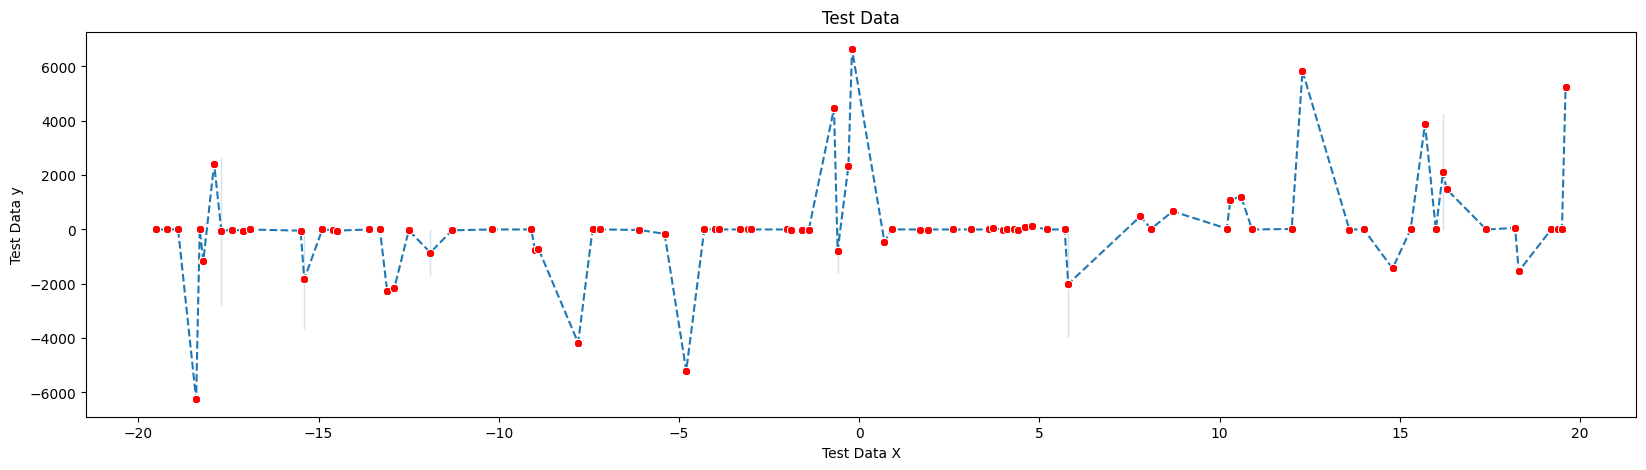

In [15]:
#ploting test data

plt.figure(figsize=(20,5))
sns.lineplot(x = test_data['x'], y = test_data['y'],marker="8",markerfacecolor="red", linestyle="--")
plt.xlabel('Test Data X')
plt.ylabel('Test Data y')
plt.title('Test Data')
plt.show()

In [16]:
#### Unit TEST #####

class testsum(TestCase):
    def test_1(self):
        # setting  func
        dataset1 ={"x":[1.0,2.0,3.0],"y":[5.0,6.0,7.0]}
        self.data_frame_1 = pd.DataFrame(data = dataset1)

        dataset2 ={"x":[1.0,2.0,3.0],"y":[7.0,8.0,9.0]}
        self.data_frame_2 = pd.DataFrame(data = dataset2)

        self.function_1 = Func("name")
        self.function_1.dataframe = self.data_frame_1

        self.function_2 = Func("name")
        self.function_2.dataframe = self.data_frame_2

    def test_2(self):
        pass

    def test_3(self):
        
        # 1: A rudimentary evaluation to determine if the loss function is computing an accurate value.

        self.assertEquals(squared_err(self.function_1, self.function_2),12.0)

        # 2: straightforward test in case misfortune work is acquainted

        self.assertEquals(squared_err(self.function_2, self.function_1),12.0)

        # 3: hell in case relapse of two rise to capacities is

        self.assertEquals(squared_err(self.function_1, self.function_1),0.0)


